In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import glob
import wget
import PIL
from random import randint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_dir = "dog-breed-identification/"

In [3]:
labels = pd.read_csv(os.path.join(dataset_dir,'labels.csv'))

In [4]:
labels.shape
#1st parameter show the number of row
#2nd parameter show number of column

(10222, 2)

In [5]:
labels.head
# id = name of the photo
# breed = breed of dog in that particular photo

<bound method NDFrame.head of                                      id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]>

In [6]:
labels.describe()
# show the number of photo and breed
# unique = number of breed

,id,breed
count,10222,10222
unique,10222,120
top,e3b794cfccf2ed02689f046aebe7f650,scottish_deerhound
freq,1,126


In [7]:
# put all the breed into the class array 
classes_name = np.unique(labels['breed'])

print(f"The total number of breed in the dataset are {len(classes_name)}")

The total number of breed in the dataset are 120


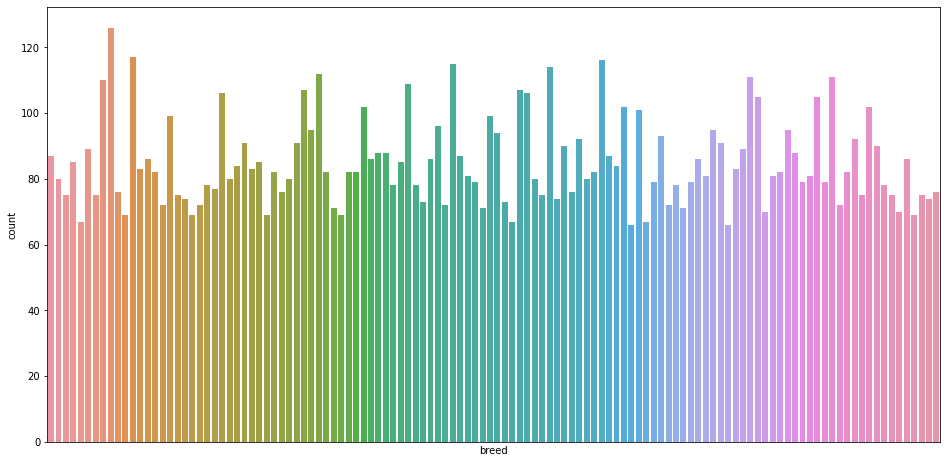

In [8]:
# analyse number of breed with number of photo with dog

plt.figure(figsize=(16,8))
sns.countplot(labels['breed'])
plt.xticks([])
plt.show()

In [9]:
# encoding the breed in the labels file with a unique integer id
lb_encoder = LabelEncoder()
newlabels = lb_encoder.fit_transform(labels['breed']).reshape(-1,1)

newlabels.shape

(10222, 1)

In [10]:
newlabels[:10]

array([[19],
       [37],
       [85],
       [15],
       [49],
       [10],
       [10],
       [18],
       [ 7],
       [97]])

In [51]:
# to remove the priority between id for each dog breed 
ot_encoder = OneHotEncoder()

newlabels = ot_encoder.fit_transform(newlabels).toarray()
newlabels[:10]

array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

# Preprocessing for Training set

In [12]:
train_path = os.path.join(dataset_dir,'train/')

In [13]:
#load all the images path from labels.csv
images_path = [train_path + id + ".jpg" for id in labels["id"]]

images_path[:5]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [14]:
# preprocess the image

IMG_SIZE = 224

def process_image(img_path):
    # read the image
    img = tf.io.read_file(img_path)
    # convert the image to tensor type
    img = tf.image.decode_jpeg(img,channels=3)
    # standardize data from (0,255) -> (0,1)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    # resize the image
    img = tf.image.resize(img, size=[IMG_SIZE,IMG_SIZE])
    return img

In [15]:
# process the image and make sure the label locked with image
def get_img_label(img_path,label):
    image = process_image(img_path)
    return image,label

In [16]:
def train_data_split(images, labels, ratio=0.4):
    # images = all the image path
    # labels = all the labels
    # ratio
    
    x_train, x_val, y_train, y_val = train_test_split(images,labels, test_size=ratio,random_state=666)
    
    return x_train, x_val, y_train, y_val

In [17]:
x_train, x_val, y_train, y_val = train_data_split(images_path,newlabels, ratio=0.4)

In [18]:
# split the dataset into groups for the model to train
BATCH_SIZE = 32

def create_batch_data(X, y=None, batch_size=BATCH_SIZE, data_type=3):
    # X = image path
    # y = label
    # batch size = group size 
    # data_type 1:test data, 2:Valid data, 3: train data
    
    if data_type==1:
        # process indication print statement for confirmation
        print("Creating data batch from test data")
        # convert `X` into tensors
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        # process the image by calling preprocess function and create databatches from them
        data_batch = data.map(process_image).batch(batch_size)
        # returns the processed batch datasets
        return data_batch
    elif data_type==2:
        # process indication print statement for confirmation
        print("Creating data batch from validation data")
        # convert `X`&`y` into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        # process the image by calling get_image_label function and create databatches from them
        data_batch = data.map(get_img_label).batch(batch_size)
        # returns the processed batch datasets
        return data_batch
    else:
        # process indication print statement for confirmation
        print("Creating data batch from training data")
        # convert `X`&`y` into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        # shuffle the whole data before making them as batches
        data = data.shuffle(buffer_size=len(X))
        # process the image by calling get_image_label function and create databatches from them
        data_batch = data.map(get_img_label).batch(batch_size)
        # returns the processed batch datasets
        return data_batch

In [19]:
# creating train data batches
train_data = create_batch_data(x_train, y_train, data_type=3)
# creating validation data batches
val_data = create_batch_data(x_val, y_val, data_type=2)

Creating data batch from training data
Creating data batch from validation data


In [20]:
def show_img(images,labels):
    batches = len(images)
    # create a figure
    plt.figure(figsize=(16,8))
    # loop to iterate each image in the batch(unbatched images) and plot them
    for i in range(batches):
        # adding subplot in (i+1) postion
        plt.subplot(4, 8, i+1)
        # show image in postion (i)
        plt.imshow(images[i])
        # add breed of the dog as title 
        plt.title(classes_name[np.argmax(labels[i])])
        # remove (X & Y) axis to get clear image
        plt.axis('off')

In [21]:
samplesData,samplesLabel = next(train_data.as_numpy_iterator())
samplesData.shape

(32, 224, 224, 3)

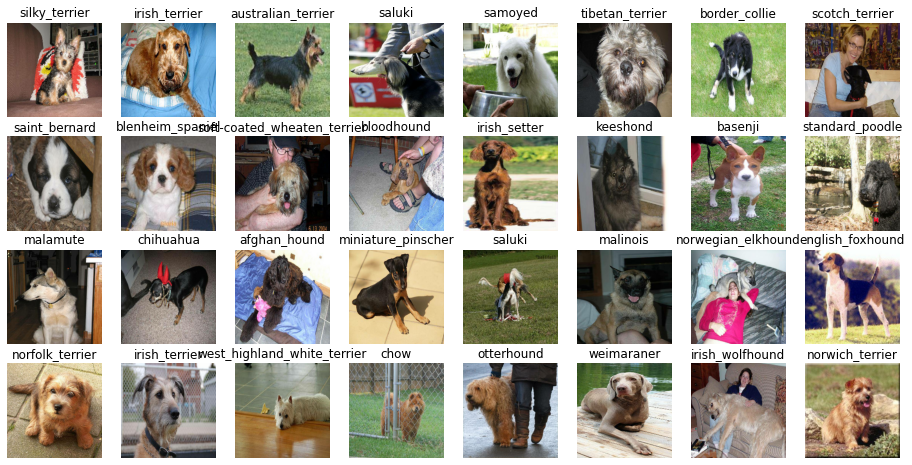

In [22]:
show_img(samplesData,samplesLabel)

# Transfer Learning model

In [23]:
INPUT_SHAPE = (None, IMG_SIZE,IMG_SIZE,3) 

OUTPUT_SHAPE = len(classes_name)
# url of chosen model from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

In [24]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    # instantiating model with keras Sequential api
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer) layer of pretrained model from tf hub
        tf.keras.layers.Dense(units=output_shape, # Layer 2 (output layer)
            activation="softmax") # multiclass claffication hence 'softmax' activation function 
    ])
    # compiling with 'Adam' optimizer and 'accuracy' metrics
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    
    # building the model
    model.build(input_shape)
    # returns the created model
    return model

In [25]:
# creating model using our `create_model()`function
model = create_model()

In [26]:
# viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,628,953
Trainable params: 120,240
Non-trainable params: 5,508,713
_________________________________________________________________


In [27]:
# loading tensorboard extension into notebook
%load_ext tensorboard

In [28]:
# remove the previous log file
!rm -rf ./logdir/

In [29]:
logdir = os.path.join('logdir', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
# create the TensorBoard Callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [30]:
# early stopping callback for model training with 1000 images
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3) 
# monitor = monitoring validation accuracy since we got validation data for this model
# patience = wait for 3 epochs before terminating the training in case of overfitting

# Training model, validating and testing

In [31]:
# Training times
EPOCHS = 30

model.fit(x=train_data,
          epochs=EPOCHS,
          validation_data=val_data,
          callbacks=[tensorboard_callback, early_stopping])

Epoch 1/30
192/192 [==============================] - 315s 2s/step - loss: 1.7770 - accuracy: 0.5960 - val_loss: 0.7773 - val_accuracy: 0.7831
Epoch 2/30
192/192 [==============================] - 311s 2s/step - loss: 0.4248 - accuracy: 0.8844 - val_loss: 0.7062 - val_accuracy: 0.7931
Epoch 3/30
192/192 [==============================] - 373s 2s/step - loss: 0.2206 - accuracy: 0.9488 - val_loss: 0.6859 - val_accuracy: 0.8031
Epoch 4/30
192/192 [==============================] - 420s 2s/step - loss: 0.1319 - accuracy: 0.9791 - val_loss: 0.6976 - val_accuracy: 0.8029
Epoch 5/30
192/192 [==============================] - 393s 2s/step - loss: 0.0850 - accuracy: 0.9914 - val_loss: 0.6840 - val_accuracy: 0.8070
Epoch 6/30
192/192 [==============================] - 484s 3s/step - loss: 0.0605 - accuracy: 0.9962 - val_loss: 0.6942 - val_accuracy: 0.8039
Epoch 7/30
192/192 [==============================] - 415s 2s/step - loss: 0.0448 - accuracy: 0.9980 - val_loss: 0.7025 - val_accuracy: 0.8080

In [32]:
# fetching tensorboard logs & displaying them
%tensorboard --logdir logdir

# Test the model with test data set

In [33]:
#model test data
test_path = os.path.join(dataset_dir,'test')

test_images_path = glob.glob(train_path+'/*.jpg')

test_images_path[:5]

['dog-breed-identification/train/84accc2dc9f5bb3ebee89fe1bf23639c.jpg',
 'dog-breed-identification/train/14cffe576239620f1733dfe487dbaa6f.jpg',
 'dog-breed-identification/train/cc93915e06bc55626a02af95006a48c2.jpg',
 'dog-breed-identification/train/6f9bac41b5be5ee6baecc9e7ef8f2c2a.jpg',
 'dog-breed-identification/train/64dd586a1d08937d20618233df2e5dbc.jpg']

In [34]:
test_data = create_batch_data(test_images_path,batch_size=1, data_type=1)

Creating data batch from test data


In [35]:
# predicting test labels using '.predict()' method
test_prediction = model.predict(test_data, verbose=1)

10222/10222 [==============================] - 502s 49ms/step


In [36]:
test_prediction[0]

array([8.66910099e-09, 1.16014904e-08, 4.51829756e-08, 1.65422147e-08,
       5.06916649e-07, 2.44190570e-08, 3.41848931e-08, 4.24019618e-07,
       1.75392074e-08, 1.96982296e-06, 1.50196954e-07, 9.03619757e-09,
       4.73185509e-07, 2.80269852e-08, 7.23402025e-07, 2.71076495e-08,
       2.54769784e-05, 4.66019436e-08, 1.44313453e-05, 1.36658294e-08,
       3.99610286e-07, 7.75373621e-07, 1.92606175e-09, 2.31813169e-06,
       2.66110419e-06, 4.07185352e-09, 3.79607656e-07, 4.56467023e-06,
       3.33050048e-06, 5.44110890e-09, 3.56913603e-07, 1.49266228e-07,
       1.44163778e-07, 8.83237772e-06, 5.05189206e-08, 1.32444855e-09,
       1.08733701e-07, 2.03941028e-07, 4.33957621e-06, 1.33270515e-08,
       6.78802608e-05, 5.85255350e-07, 7.56345230e-07, 1.85559882e-04,
       7.42688062e-05, 1.15801285e-07, 3.82814534e-07, 3.90142496e-08,
       1.86894535e-08, 8.61907949e-07, 1.54130131e-08, 8.20135597e-07,
       6.11268282e-01, 8.81130688e-07, 3.15949592e-07, 1.99990353e-07,
      

In [37]:
# get the maximum of possibilities in the 1st test photo
max_test_01_prob = np.max(test_prediction[0])

print(f'The maximum probability is {max_test_01_prob}')

The maximum probability is 0.6112682819366455


In [38]:
# get the index and label for maximum probability
max_test_01_index = np.argmax(test_prediction[0])
max_test_01_label = classes_name[max_test_01_index]

print(f'The maximum probability is located at index {max_test_01_index} and named {max_test_01_label}')

The maximum probability is located at index 52 and named great_pyrenees


In [39]:
def show_test_img(img_path,prob):
    # preprocess the test image
    test_image = process_image(img_path)
    # get the label predicted using model
    pred_label = classes_name[np.argmax(prob)]
    
    maxprob = round(np.max(prob),2)
    titlename = f'prob:{str(maxprob)},label:{pred_label}'
    plt.imshow(test_image)
    plt.axis('off')
    plt.title(titlename)

In [40]:
def show_top10_img(pred_prob):
    top10_prob_indices = pred_prob.argsort()[-10:][::-1]
    top10_prob_values = pred_prob[top10_prob_indices]
    top10_prob_labels = classes_name[top10_prob_indices]
    plt.bar(np.arange(len(top10_prob_indices)),
            top10_prob_values,
            color="blue")
    plt.xticks(np.arange(len(top10_prob_indices)),
               top10_prob_labels,
               rotation='vertical')

In [41]:
def show_test_prediction(numbers =3):
    plt.figure(figsize=(16,8))
    for i in range(numbers):
        # adding subplot in (i+1) postion
        num = randint(0,len(test_prediction)-1)
        plt.subplot(numbers, 2, 2*i+1)
        show_test_img(test_images_path[num],test_prediction[num])
        plt.subplot(numbers, 2, 2*i+2)
        show_top10_img(test_prediction[num])
    
    plt.show()

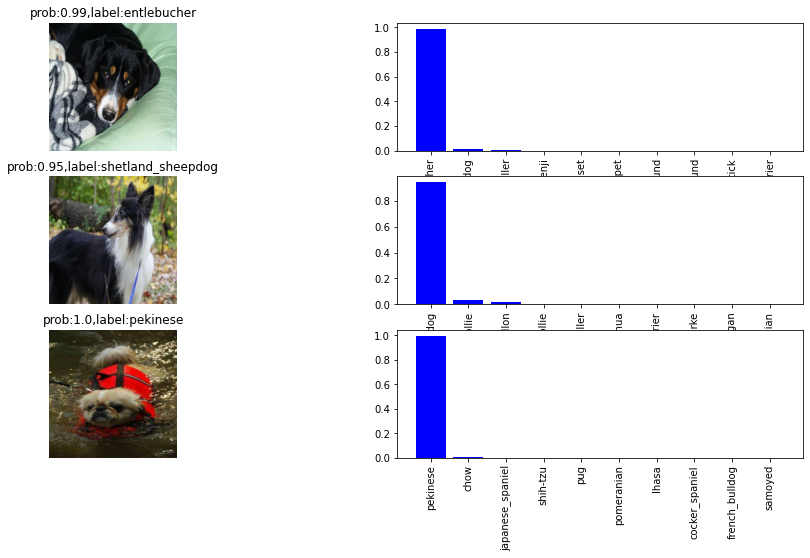

In [42]:
show_test_prediction(numbers=3)

# Prediction with random photo from internet

In [43]:
url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKy1FURMOTMGrRzhbi33WR5YvLJ-nTf7Bm5A&usqp=CAU'

In [44]:
# download the photo

test_img_01 = wget.download(url,'Golden_Retriever.jpg')

In [45]:
# process the image
test_img_01_data = create_batch_data(X=['Golden_Retriever.jpg'],y=None,batch_size=1,data_type=1)

Creating data batch from test data


In [46]:
test_result = model.predict(test_img_01_data)

The maximum probability of the photo is 0.999600350856781 and its label is golden_retriever


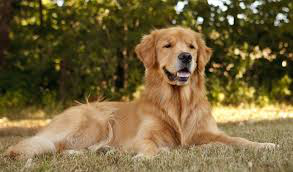

In [47]:
best_prob = np.max(test_result)
prob_label = classes_name[np.argmax(test_result)]

print(f'The maximum probability of the photo is {best_prob} and its label is {prob_label}')
PIL.Image.open(test_img_01)

# Prediction with noises photo

In [58]:
# process the image
test_img_02 = 'Noisy_Dog_Image.jpg'
test_img_02_data = create_batch_data(X=['Noisy_Dog_Image.jpg'],y=None,batch_size=1,data_type=1)

Creating data batch from test data


In [59]:
test_result = model.predict(test_img_02_data)

The maximum probability of the photo is 0.2806219458580017 and its label is otterhound


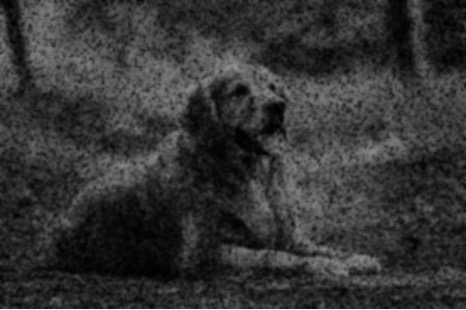

In [60]:
best_prob = np.max(test_result)
prob_label = classes_name[np.argmax(test_result)]

print(f'The maximum probability of the photo is {best_prob} and its label is {prob_label}')
PIL.Image.open(test_img_02)

# Saving the model

In [48]:
#save and download the model
model.save("model.h5")

In [49]:
model = load_model("model.h5",custom_objects={"KerasLayer" : hub.KerasLayer})

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,628,953
Trainable params: 120,240
Non-trainable params: 5,508,713
_________________________________________________________________
